In [25]:
import torch.nn as nn
import torch
import torchvision
import time
from IPython import display
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
FILENAME = '/home/data'
from PIL import Image
import torch.nn.functional as F
import sys
device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')

In [26]:
image = Image.open('/home/Image_add/cat.jpg')

In [27]:
def show_images(imgs,num_rows,num_cols,scales=2):
    figsize = (num_cols*scales,num_rows*scales)
    _,img = plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            img[i][j].imshow(imgs[i*num_cols+j])
            img[i][j].axes.get_xaxis().set_visible(False)
            img[i][j].axes.get_yaxis().set_visible(False)
    return img

In [28]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y = [aug(img)for _ in range(num_cols*num_rows)]
    show_images(Y,num_rows,num_cols,scale)

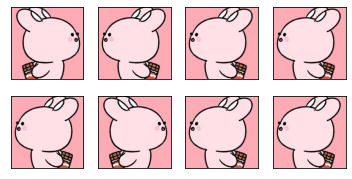

In [29]:
apply(image,torchvision.transforms.RandomHorizontalFlip())

In [30]:
all_images = torchvision.datasets.CIFAR10(root=FILENAME,train=True,download=True)

Files already downloaded and verified


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

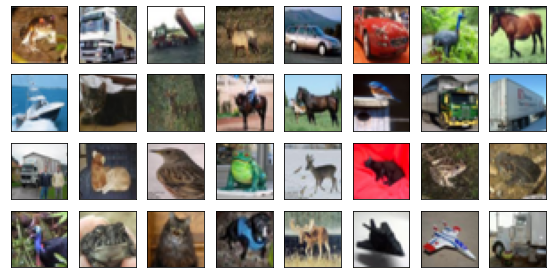

In [31]:
show_images([all_images[i][0] for i in range(32)],4,8,1.2)

In [32]:
filp_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
no_aug = transforms.Compose([transforms.ToTensor()])

In [33]:
class GlobalAverageLayer(nn.Module):
    def __init__(self):
        super(GlobalAverageLayer,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [34]:
if sys.platform.startswith('win'):
    num_workers=4
else:
    num_workers=0
def load_cifar(is_train,aug,batch_size,root=FILENAME):
    dataset = torchvision.datasets.CIFAR10(root=root,train=is_train,transform=aug,download=True)
    return torch.utils.data.DataLoader(dataset,batch_size,shuffle=is_train,num_workers=num_workers) 

In [35]:
class Residual_block(nn.Module):
    def __init__(self,in_channels,out_channels,is_use1x1conv=False,stride=1):
        super(Residual_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_channels)
        )
        if is_use1x1conv:
            self.conv3 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else:
            self.conv3 = None
        self.end = nn.Sequential(nn.ReLU())
    def forward(self,x):
        y = self.conv(x)
        if self.conv3:
            x = self.conv3(x)
        output = self.end(y+x)
        return output
        

In [36]:
blk = Residual_block(3, 3)
X = torch.rand((4, 3, 6, 6))
blk(X).shape

torch.Size([4, 3, 6, 6])

In [37]:
net = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

In [38]:
def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
    if first_block:
        assert in_channels==out_channels
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual_block(in_channels,out_channels,is_use1x1conv=True,stride=2))
        else:
            blk.append(Residual_block(out_channels,out_channels))
    return nn.Sequential(*blk)

In [39]:
net.add_module("resnet_block1",resnet_block(64,64,2,first_block=True))
net.add_module("resnet_block2",resnet_block(64,128,2))
net.add_module("resnet_block3",resnet_block(128,256,2))
net.add_module("resnet_block4",resnet_block(256,512,2))
net.add_module("Global_average_poll",GlobalAverageLayer())
net.add_module("fc",nn.Sequential(FlattenLayer(),nn.Linear(512,10)))

In [40]:
X = torch.rand((1, 3, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
Global_average_poll  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


In [41]:
batch_size=256
train_iter = load_cifar(True,filp_aug,batch_size,root=FILENAME)
test_iter =  load_cifar(False,no_aug,batch_size,root=FILENAME)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
def evaculate_accuracy(data_iter,net,device):
    acc_sum=0.0
    n = 0 
    with torch.no_grad():
        for X,Y in data_iter:
            if isinstance(net,nn.Module):
                net.eval()
                acc_sum += (net(X.to(device)).argmax(dim=1)==Y.to(device)).float().sum().cpu().item()
                net.train()
            else:
                if ('is_training' in  net.__code__.co_varnames):
                    acc_sum += (net(X,is_training=False).argmax(dim=1)==Y).float().sum().itme()
                else:
                    acc_sum += (net(X).argmax(dim=1)==Y).float().sum().itme()
            n +=Y.shape[0]
        return acc_sum/n

In [51]:
def train_ch9(net,train_iter,test_iter,optimizer,device,num_epochs):
    loss = nn.CrossEntropyLoss()
    net=net.to(device)
    print('train on:',device)
    for epochs in range(num_epochs):
        train_loss = 0.0
        train_acc_sum = 0.0
        n = 0
        batch_cout = 0
        start = time.time()
        for X,Y in train_iter:
            X = X.to(device)
            Y = Y.to(device)
            y_hat = net(X)
            l = loss(y_hat,Y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_loss += l.cpu().item()
            train_acc_sum += (net(X).argmax(dim=1)==Y).float().sum().cpu().item()
            n += Y.shape[0]
            batch_cout +=1
        print(n,batch_cout)
        test_acc_sum = evaculate_accuracy(test_iter,net,device)
        print('epoch:%d,loss:%.3f,train_acc_sum:%.3f,test_acc_sum:%.3f,time:%.3f'%(epochs+1,train_loss/batch_cout,train_acc_sum/n,test_acc_sum,time.time()-start))


In [52]:
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
train_ch9(net,train_iter,test_iter,optimizer,device,10)

train on: cuda
50000 196
epoch:1,loss:0.147,train_acc_sum:0.983,test_acc_sum:0.780,time:12.089
50000 196
epoch:2,loss:0.129,train_acc_sum:0.986,test_acc_sum:0.774,time:12.023
50000 196
epoch:3,loss:0.124,train_acc_sum:0.988,test_acc_sum:0.784,time:11.850
50000 196
epoch:4,loss:0.112,train_acc_sum:0.991,test_acc_sum:0.782,time:12.252
50000 196
epoch:5,loss:0.108,train_acc_sum:0.990,test_acc_sum:0.785,time:12.101
50000 196
epoch:6,loss:0.096,train_acc_sum:0.993,test_acc_sum:0.783,time:12.498
50000 196
epoch:7,loss:0.103,train_acc_sum:0.992,test_acc_sum:0.788,time:12.275
50000 196
epoch:8,loss:0.088,train_acc_sum:0.993,test_acc_sum:0.785,time:12.082
50000 196
epoch:9,loss:0.079,train_acc_sum:0.995,test_acc_sum:0.791,time:12.279
50000 196
epoch:10,loss:0.079,train_acc_sum:0.995,test_acc_sum:0.766,time:12.375
